In [26]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

# Contextualização: 

Bem-vindo à Machine Learning Housing Corporation!
A primeira tarefa que lhe é atribuída é construir um modelo de preços de imóveis na Califórnia utilizando os dados do censo da Califórnia. Esses dados contêm métricas como população, renda mediana, preço mediano dos imóveis, entre outras, para cada block group da Califórnia. Block groups são a menor unidade geográfica para a qual o US Census Bureau publica dados amostrais (um block group normalmente possui uma população entre 600 e 3.000 pessoas). Vamos chamá-los simplesmente de “distritos” para simplificar. Seu modelo deve aprender a partir desses dados e ser capaz de prever o preço mediano dos imóveis em qualquer distrito, dadas todas as outras métricas disponíveis.

A primeira pergunta que você deve fazer ao seu chefe é qual é exatamente o objetivo de negócio; construir um modelo provavelmente não é o objetivo final. Como a empresa espera usar esse modelo e se beneficiar dele? Isso é importante porque determinará como você irá formular o problema, quais algoritmos irá selecionar, qual medida de desempenho usará para avaliar o modelo e quanto esforço deverá gastar ajustando-o. Seu chefe responde que a saída do seu modelo (uma previsão do preço mediano dos imóveis de um distrito) será alimentada em outro sistema de Machine Learning (ver Figura 2-2), juntamente com muitos outros sinais. Esse sistema posterior determinará se vale a pena ou não investir em uma determinada área. Acertar isso é fundamental, pois afeta diretamente a receita.

A próxima pergunta a ser feita é como é a solução atual (se existir). Ela frequentemente fornece uma referência de desempenho, além de insights sobre como resolver o problema. Seu chefe responde que, atualmente, os preços dos imóveis por distrito são estimados manualmente por especialistas: uma equipe reúne informações atualizadas sobre um distrito e, quando não consegue obter o preço mediano dos imóveis, faz uma estimativa usando regras complexas. Esse processo é caro e demorado, e as estimativas não são muito boas; nos casos em que conseguem descobrir o preço mediano real dos imóveis, frequentemente percebem que as estimativas estavam erradas em mais de 20%. É por isso que a empresa acredita que seria útil treinar um modelo para prever o preço mediano dos imóveis de um distrito com base em outros dados sobre esse distrito. Os dados do censo parecem ser um excelente conjunto de dados para explorar esse propósito, pois incluem os preços medianos dos imóveis de milhares de distritos, além de outras informações relevantes.

Muito bem, com todas essas informações você já está pronto para começar a projetar seu sistema. Primeiro, você precisa formular o problema: ele é supervisionado, não supervisionado ou de Reinforcement Learning? É uma tarefa de classificação, regressão ou outra coisa? Você deve usar técnicas de aprendizado em lote (batch learning) ou aprendizado online?

Antes de continuar a leitura, pause e tente responder a essas perguntas por conta própria.

Você encontrou as respostas? Vamos ver: trata-se claramente de uma tarefa típica de aprendizado supervisionado, já que você recebe exemplos de treinamento rotulados (cada instância vem com a saída esperada, isto é, o preço mediano dos imóveis do distrito). Além disso, é também uma tarefa típica de regressão, pois você está tentando prever um valor numérico. Mais especificamente, este é um problema de regressão múltipla, já que o sistema usará múltiplas características para fazer a previsão (como população do distrito, renda mediana etc.). Também é um problema de regressão univariada, pois estamos tentando prever apenas um único valor para cada distrito. Se estivéssemos tentando prever múltiplos valores por distrito, seria um problema de regressão multivariada. Por fim, não há um fluxo contínuo de dados entrando no sistema, não existe uma necessidade particular de se ajustar rapidamente a dados em mudança, e o conjunto de dados é pequeno o suficiente para caber na memória. Portanto, o aprendizado em lote (batch learning) simples é mais do que suficiente.

# 1. Exploratory Data Analisys (EDA)

In [27]:
housing = pd.read_csv("../datasets/housing.csv")
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## 1.1 Exploração inicial

In [28]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


```python 
# - Total de linhas     20640
# - longitude           20640 -> ok
# - latitude            20640 -> ok
# - housing_median_age  20640 -> ok
# - total_rooms         20640 -> ok
# - total_bedrooms      20433 -> 207 linhas vazias (ATENÇÃO)
# - population          20640 -> ok
# etc 
```

O número percentual de linnhas vazias na coluna total_bedrooms: 207 / 20640 ≈ 1%

# 2. Train set x Test set

Poderíamos utilizar train_test_split

```python 
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(
    housing, test_size=0.2, random_state=42
)
``` 

Essa função:

- Embaralha os dados
- Separa 80% para treino e 20% para teste 
- Porém isso não garante que variáveis importantes tenham a mesma distribuição (podendo gerar viés amostral)

Porém, conhecemos uma feature crítica para a análise que estamos fazendo: "median_income". Com isso em mente, antes de criar os datasets, precisamos criar uma feature nova que agrupa os valores em determinadas categorias. Além disso, precisamos de outro método para a criação dos dasets de treino e teste para que evitemos sampling bias.

In [29]:
housing["income_cat"] = pd.cut(
    x=housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, float('inf')],
    labels=[1, 2, 3, 4, 5])

# 0.0 a 1.5 (15k) -> 1 
# 1.5 a 3.0 -> 2 
# 3.0 a 4.5 - > 3 
# 4.5 a 6.0 -> 4 
# 6.0 a inf - > 5 
housing["income_cat"]

0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

Text(0.5, 0, 'Category')

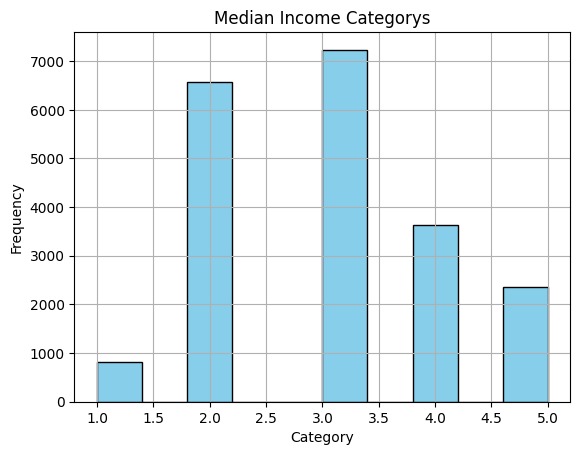

In [30]:
housing["income_cat"].hist(bins=10, color='skyblue', edgecolor='black')
plt.title("Median Income Categorys")
plt.ylabel("Frequency")
plt.xlabel("Category")

### Viés de Amostragem (Sampling Bias)

Sampling bias acontece quando o conjunto de dados usado (especialmente o de teste) não representa bem a população real. Onde exatamente está o sampling bias? Não está no algoritmo, não está no treinamento, não está nas features, **está na forma como o test set é construído**. E por que isso quebra a avaliação? Imagine poucas regiões ricas no teste, como casas caras são difíceis de prever e o modelo normalmente erra mais nelas, o erro médio fica artificialmente baixo, logo você acha que o modelo é ótimo mas ele só foi pouco testado onde mais erra. Agora imagine o contrário, muitas regiões ricas no teste implicam em muitas casas caras, logo muitos erros grandes, assim você acha que o modelo é ruim mas ele foi testado mais forte do que deveria. 

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,                    # n_splits=1 -> Crie uma única divisão treino–teste
    test_size=0.2,                 # test_size=0.2 -> O dataset de treino e de teste terão respectivamente 80% e 20% do tamanho original
    random_state=42                # random_state=42 -> Mantém a aleatoriedade constante mesmo rodando o código várias vezes
)


for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    housing_train = housing.loc[train_idx]
    housing_test = housing.loc[test_idx]

O que o trecho acima faz de diferente

- Usa uma variável de estratificação (income_cat)
- Divide os dados em estratos (grupos homogêneos)
- Garante que a proporção de cada estrato seja mantida
- Ainda assim embaralha aleatoriamente dentro de cada estrato

Ou seja, o teste “parece” com o treino no que importa.

<Axes: xlabel='longitude', ylabel='latitude'>

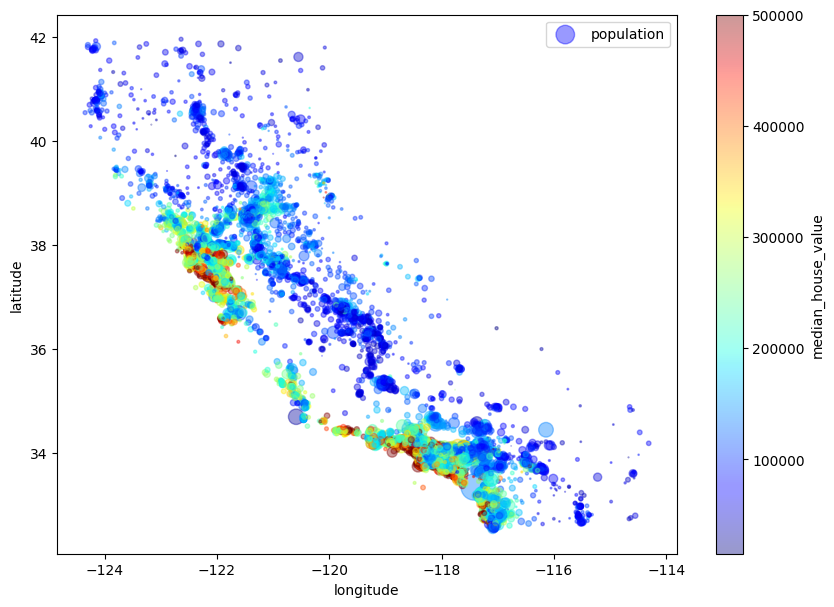

In [32]:
housing_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing_train["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

### Quando usar cada um: 

- Use split aleatório simples quando: **dataset é enorme**, **distribuição é bem homogênea**, **nenhuma variável domina o target**
- Use estratificação quando: **variável importante é desbalanceada**, **dataset é médio ou pequeno**, **você já conhece uma feature crítica**

# 3. Preparando ambiente para treino

In [33]:
# Criando cópias do datasets gerados
housing_train_copy = housing_train.copy()
housing_test_copy = housing_test.copy()

# Apagando a coluna "income_cat", dado que ela só serviu para a estratificação
housing_train_copy.drop("income_cat", axis=1, inplace=True)
housing_test_copy.drop("income_cat", axis=1, inplace=True)

# Separação de features e target (Impoartante para evitar 'data leakage')
X_train_raw = housing_train_copy.drop("median_house_value", axis=1)
X_test_raw = housing_test_copy.drop("median_house_value", axis=1)

y_train = housing_train_copy["median_house_value"].copy() # target de treino 
y_test = housing_test_copy["median_house_value"].copy()   # target de teste 

**Data leakage (vazamento de dados)** acontece quando o modelo aprende, direta ou indiretamente, informações que ele não deveria ter no momento da previsão. Em outras palavras, o modelo recebe “cola” sobre a resposta correta.

Isso pode acabar gerando uma dúvida: “Se é aprendizado supervisionado, o modelo não deveria ter acesso ao target?”

Resposta: Sim, o modelo tem acesso ao target mas SOMENTE no momento certo e do jeito certo. Ele não pode ter acesso ao target como entrada (feature), durante o pré-processamento ou no momento da previsão. 

Em aprendizado supervisionado, o target é usado apenas para ensinar o modelo, não para ajudá-lo a “colar”.

# 4. Preparando os dados para algoritmos de Machine Learning

## 4.1 Tratando dados categóricos

Modelos de Machine Learning trabalham com números, mas muitos dados são categóricos (texto). Nesses casos, utilizamos o One-Hot Encoding para transformar uma variável categórica em várias variáveis binárias (0 ou 1), uma para cada categoria.

In [34]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown="ignore")
ocean_proximity_cat = cat_encoder.fit_transform(X_train_raw[["ocean_proximity"]])

print("Variáveis categóricas agora separadas em features: ", cat_encoder.categories_[0])
print("\n")
print("Distribuição dos valores em uma matrix esparsa:")
print(ocean_proximity_cat.toarray())

Variáveis categóricas agora separadas em features:  ['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


Distribuição dos valores em uma matrix esparsa:
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [35]:
category = pd.DataFrame(
    ocean_proximity_cat.toarray(),          
    columns=cat_encoder.categories_[0],  
    index=X_train_raw.index              
)
category


,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,0.0,1.0,0.0,0.0,0.0
15502,0.0,0.0,0.0,0.0,1.0
2908,0.0,1.0,0.0,0.0,0.0
14053,0.0,0.0,0.0,0.0,1.0
20496,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
15174,1.0,0.0,0.0,0.0,0.0
12661,0.0,1.0,0.0,0.0,0.0
19263,1.0,0.0,0.0,0.0,0.0
19140,1.0,0.0,0.0,0.0,0.0


In [36]:
X_train_raw = X_train_raw.join(category)
X_train_raw.drop("ocean_proximity", axis=1, inplace=True)
X_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   <1H OCEAN           16512 non-null  float64
 9   INLAND              16512 non-null  float64
 10  ISLAND              16512 non-null  float64
 11  NEAR BAY            16512 non-null  float64
 12  NEAR OCEAN          16512 non-null  float64
dtypes: float64(13)
memory usage: 2.3 MB


## 4.2 Tratando espaços vazios

Muitos algoritmos não aceitam valores ausentes (NaN) ou quebram silenciosamente ou aprendem errado

- Não é indicado remover linhas, pois isso acarreta na perda de dados e na possibilidade de introduzir viés
- Remover a coluna inteira também não é interessante, pois perderemos informações potencialmente importantes

Ao invés disso, preencheremos os espaços vazios com a mediana, pois a mediana é robusta frente a valores extremos (outliers). Além disso, a mediana representa melhor o “valor típico”, enquanto muitas vezes, em dados reais, a média pode enganar.

In [37]:
total_bedrooms_median = X_train_raw["total_bedrooms"].median()
X_train_raw["total_bedrooms"] = X_train_raw["total_bedrooms"].fillna(total_bedrooms_median)
X_train_raw

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,0.0,1.0,0.0,0.0,0.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,0.0,0.0,0.0,0.0,1.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,0.0,1.0,0.0,0.0,0.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,0.0,0.0,0.0,0.0,1.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,1.0,0.0,0.0,0.0,0.0
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,0.0,1.0,0.0,0.0,0.0
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,1.0,0.0,0.0,0.0,0.0
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,1.0,0.0,0.0,0.0,0.0


# 5. Feature Engineering

criando novas variáveis mais informativas, porque: “Algoritmos aprendem melhor quando damos sinais mais significativos.

In [38]:
# Criando features novas 

# Quartos por domicílio
X_train_raw["rooms_per_household"] = (
    X_train_raw["total_rooms"] / X_train_raw["households"]
)

# População por domicílio 
X_train_raw["population_per_household"] = (
    X_train_raw["population"] / X_train_raw["households"]
)

# Proporção de dormitórios
X_train_raw["bedrooms_per_room"] = (
    X_train_raw["total_bedrooms"] / X_train_raw["total_rooms"]
)

X_train_raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,rooms_per_household,population_per_household,bedrooms_per_room
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,533.939438,1419.687379,497.011810,3.875884,0.440710,0.318677,0.000121,0.111858,0.128634,5.440406,3.096469,0.213698
std,2.001828,2.137963,12.574819,2138.417080,410.806260,1115.663036,375.696156,1.904931,0.496487,0.465978,0.011005,0.315201,0.334804,2.611696,11.584825,0.065344
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,0.000000,0.000000,0.000000,0.000000,0.000000,1.130435,0.692308,0.036980
25%,-121.800000,33.940000,18.000000,1443.000000,296.000000,784.000000,279.000000,2.566950,0.000000,0.000000,0.000000,0.000000,0.000000,4.442168,2.431352,0.175054
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,0.000000,0.000000,0.000000,0.000000,0.000000,5.232342,2.817661,0.203046
75%,-118.010000,37.720000,37.000000,3141.000000,641.000000,1719.000000,602.000000,4.745325,1.000000,1.000000,0.000000,0.000000,0.000000,6.056361,3.281420,0.240126
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,1.000000,1.000000,1.000000,1.000000,1.000000,141.909091,1243.333333,2.811688


Por que fazer isso agora?

Modelos não entendem contexto, eles só veem números então nós precisamos transformar números em sinais úteis. Criar novas features não é inventar dados, é expressar melhor a informação que já existe.

- total_rooms sozinho é pouco informativo (Exemplo: Distrito A - 1000 cômodos e 100 casas; Distrito B - 1000 cômodos e 500 casas)
- total_bedrooms sozinho é pouco informativo 
- Relações são mais importantes que valores absolutos

Melhores dados -> melhor modelo

# 6. Escalonamento (Feature Scaling)

Escalonamento é o processo de colocar todas as features numéricas em escalas semelhantes.

- Não muda a informação.
- Não cria padrões novos.
- Apenas muda a “unidade de medida”.

O que o escalonamento faz:

- Ele transforma isso: total_rooms → 40.000 ; median_income → 4
- Em algo como: total_rooms → 1.2 ; median_income → 0.8

Regra importante:

O scaler é ajustado SOMENTE no conjunto de treino. Depois, ele é aplicado no teste. Você nunca ajusta no dataset inteiro, ajusta no teste, ajusta toda vez de novo. Isso evita data leakage.

Nesse caso vamos escalonar apenas as colunas numéricas contínuas.

In [39]:
quant_cat = cat_encoder.categories_[0].tolist()

num_columns = [col for col in X_train_raw.columns if col not in quant_cat]
num_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'population_per_household',
 'bedrooms_per_room']

In [40]:
X_train_num = X_train_raw[num_columns]
X_train_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,5.485836,3.168555,0.205784
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,6.927083,2.623698,0.160714
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,5.393333,2.223333,0.191595
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,3.886128,1.859213,0.276505
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,6.096552,3.167241,0.182692
...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,6.658342,2.023976,0.184696
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,5.571932,3.363188,0.179977
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,4.110465,2.662791,0.234795
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,6.297405,2.411178,0.183835


Agora que temos apenas dados numéricos podemos aplicar o 'scaler'

Aqui o scaler aprende:

- média de cada coluna
- desvio padrão de cada coluna

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_num)

,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


Transformando dados numéricos

In [42]:
X_train_num_scaled = scaler.transform(X_train_num) # Ainda não é um dataframe 
X_train_num_scaled 

# Agora os dados estão:
# - média ≈ 0
# - desvio ≈ 1

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]], shape=(16512, 11))

In [43]:
# Transformando em dataframe
X_train_scaled = pd.DataFrame(
    X_train_num_scaled,
    columns=num_columns,
    index=X_train_raw.index
)
X_train_scaled

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.017395,0.006223,-0.121122
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.569256,-0.040811,-0.810867
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,-0.018024,-0.075371,-0.338273
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,-0.595140,-0.106803,0.961205
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,0.251241,0.006109,-0.474513
...,...,...,...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374,0.466353,-0.092580,-0.443846
12661,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509,0.050362,0.023024,-0.516065
19263,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475,-0.509240,-0.037436,0.322869
19140,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261,0.328149,-0.059156,-0.457023


In [44]:
# Fazendo o join com as colunas categóricas
X_train_final = pd.concat(
    [X_train_scaled, X_train_raw[quant_cat]],
    axis=1
)
X_train_final

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.017395,0.006223,-0.121122,0.0,1.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.569256,-0.040811,-0.810867,0.0,0.0,0.0,0.0,1.0
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,-0.018024,-0.075371,-0.338273,0.0,1.0,0.0,0.0,0.0
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,-0.595140,-0.106803,0.961205,0.0,0.0,0.0,0.0,1.0
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,0.251241,0.006109,-0.474513,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374,0.466353,-0.092580,-0.443846,1.0,0.0,0.0,0.0,0.0
12661,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509,0.050362,0.023024,-0.516065,0.0,1.0,0.0,0.0,0.0
19263,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475,-0.509240,-0.037436,0.322869,1.0,0.0,0.0,0.0,0.0
19140,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261,0.328149,-0.059156,-0.457023,1.0,0.0,0.0,0.0,0.0


In [45]:
X_train_final[num_columns].std()

longitude                   1.00003
latitude                    1.00003
housing_median_age          1.00003
total_rooms                 1.00003
total_bedrooms              1.00003
population                  1.00003
households                  1.00003
median_income               1.00003
rooms_per_household         1.00003
population_per_household    1.00003
bedrooms_per_room           1.00003
dtype: float64

## Observação: Escalonamento não melhora os dados. Ele melhora o terreno onde o modelo aprende.

# 7. Treinar um modelo (baseline)

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [47]:
# Coeficientes angular da reta
a = lin_reg.coef_

# Coeficiente linear da reta 
b = lin_reg.intercept_

print("Coeficientes angular da reta: ", a)
print("Coeficiente linear da reta : ", b)

Coeficientes angular da reta:  [-55649.63398453 -56711.59742892  13734.72084192  -1943.05586355
   7343.22979731 -45709.28253579  45453.26277662  74714.15226133
   6604.58396628   1043.05452981   9248.31607777 -18015.98870784
 -55214.71083473 110357.8461062  -22484.65997391 -14642.48658971]
Coeficiente linear da reta :  236926.0618965275


# 8. Avaliando o erro quadrático médio no treino (RMSE)

In [48]:
from sklearn.metrics import mean_squared_error
import numpy as np

housing_predictions = lin_reg.predict(X_train_final)
lin_rmse = np.sqrt(mean_squared_error(y_train, housing_predictions))

print("Erro gradrático médio do nosso modelo:", lin_rmse)
print("Desvio padrão do target:", y_train.std())
print("Nosso modelo estima o valor das casas com um desvio de aproximadamente 68k a mais ou a menos")

Erro gradrático médio do nosso modelo: 68627.87390018745
Desvio padrão do target: 115701.29725026492
Nosso modelo estima o valor das casas com um desvio de aproximadamente 68k a mais ou a menos


## ATENÇÃO: DAQUI PRA BAIXO OCORREU DATA LEAKAGE (POR QUÊ?)

## Observação: **Cross-validation**

A maneira mais correta de validar o desvio de um modelo é fazendo uma **Cross-validation**. Basicamente, você pega o cojunto de dados de treino e o divide em "N" partes e repete o treino "N" vezes sempre treinando com N-1 dados e testando com 1 para assim coletar os dados estatísticos.

In [49]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(
    lin_reg,                               # modelo que utilizamos 
    X_train_final,                         # dataset de treino 
    y_train,                               # target de treino  
    scoring="neg_mean_squared_error",      # método utilizado
    cv=10                                # número de vezes que o treino será feito
)

lin_rmse_scores = np.sqrt(-lin_scores)

print("RMSE médio:", lin_rmse_scores.mean())
print("Desvio padrão:", lin_rmse_scores.std())

RMSE médio: 69104.07998247063
Desvio padrão: 2880.3282098180634


## Observação: **Coeficiente de determinação (R2)**

O coeficiente de dertminação mede o quanto da variância do alvo é explicada pelo modelo, em outras palavras "quanto do problema o modelo consegue explicar". 

In [50]:
from sklearn.model_selection import cross_val_score

r2_scores = cross_val_score(
    lin_reg,                               # modelo que utilizamos 
    X_train_final,                         # dataset de treino 
    y_train,                               # target de treino  
    scoring="r2",                          # método utilizado
    cv=10                                # número de vezes que o treino será feito
)


print("R2 médio:", r2_scores.mean())
print(f"Ou seja, o nosso modelo capturou aproximadamente {r2_scores.mean()*100:.2f}% do padrão do problema")

R2 médio: 0.6422117515199518
Ou seja, o nosso modelo capturou aproximadamente 64.22% do padrão do problema
